## Define a function to get the real distance between to lat/long points
- Manhattan distance should be useful, but I think we can do better with real distance
- Here we compare a manual calculation to the geopy library

In [1]:
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
import reverse_geocoder as rg
import numpy as np

QUEENS = (40.7282, 73.7949)
BRONX = (40.8448, 73.8648)
STATEN = (40.5795, 74.1502)
BROOKLYN = (40.6782, 73.9442)
MANHATTAN = (40.7831, 73.9712)

BURROUGHS = [('Queens', QUEENS), ('Bronx', BRONX), ('Staten', STATEN), ('Brooklyn', BROOKLYN), ('Manhattan', MANHATTAN)]

def geo_manhattan_distance(lat1, lat2, long1, long2):
    """
    returns the manhattan distance between two geo points
    """
    return abs(lat2 - lat1) + abs(long2 - long1)

def geopy_dist(coord1, coord2):
    try:
        return geopy.distance.distance(coord1, coord2).kilometers
    except:
        return -1

def haversine(lat1, lon1, lat2, lon2, m_const=3958.8):
    lat1, lon1, lat2, lon2 = map(abs, [lat1, lon1, lat2, lon2])
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    mi = m_const * c
    return mi

# filter functions to reduce the dataset
def within_boundary(dataframe, boundary):
    return (dataframe['pickup_longitude'] >= boundary[0]) & (dataframe['pickup_longitude'] <= boundary[1]) & \
            (dataframe['pickup_latitude'] >= boundary[2]) & (dataframe['pickup_latitude'] <= boundary[3]) & \
            (dataframe['dropoff_longitude'] >= boundary[0]) & (dataframe['dropoff_longitude'] <= boundary[1]) & \
            (dataframe['dropoff_latitude'] >= boundary[2]) & (dataframe['dropoff_latitude'] <= boundary[3])

def not_at_airport(dataframe):
    return ~((dataframe['pickup_to_jfk'] < 1) | (dataframe['dropoff_to_jfk'] < 1)) & \
            ~((dataframe['pickup_to_laguardia'] < 1) | (dataframe['dropoff_to_laguardia'] < 1))


def has_passengers(dataframe):
    return (dataframe['passenger_count'] != 0)
    
            

## Import our dataset
- our dataset consists of several files:
    - train.csv: our training data
    - test.csv: our testing data
    - sample_submissions.csv: A sample submission file in the correct format (columns key and fare_amount). This dummy file 'predicts' fare_amount to be $11.35 for all rows, which is the mean fare_amount from the training set.

In [2]:
import pandas as pd
import os
import sys
import random
from sklearn.model_selection import train_test_split

TOTAL_ROWS = 55423855

DATA_FILES_PATH = 'projectDataFiles/'

NYC_COORD = (40.7580, 73.9855)
JFK_COORD = (40.6413, 73.7781)
LAGUARDIA_COORD = (40.7769, 73.8740)

# NYC Boundaries
NYC_BOUNDARY = (-74.5, -72.8, 40.5, 41.8) # in format WEST, EAST, NORTH, SOUTH

# training data types
TRAINING_TYPES = {
    'fare_amount': 'float32',
    'pickup_datetime': 'str',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

COLUMNS = list(TRAINING_TYPES.keys()) + ['real_dist']

FEATURES = [item for item in COLUMNS if item != 'fare_amount']

LABEL = 'fare_amount'

def import_training_dataset_limit(file_path, row_limit=500):
    """
    function to import the dataset into a pandas dataframe.

    Takes a row limit to limit the number of rows read.
    """
    if row_limit:
        return process_df(pd.read_csv(file_path, nrows=row_limit))
    else:
        return process_df(pd.read_csv(file_path))


def get_df_list(file_path, chunksize=1000000):
    df_list = []
    counter = 0
    for df_chunk in pd.read_csv(file_path, chunksize=chunksize, dtype=TRAINING_TYPES):
        counter += 1
        print(counter)
        df_chunk = process_df(df_chunk)
        df_list.append(df_chunk)
    return df_list
        
def process_df(dataframe, train_data=True):
    pd.set_option('use_inf_as_na', True)
    dataframe['pickup_datetime'] = dataframe['pickup_datetime'].str.slice(0, 16)
    dataframe['pickup_datetime'] = pd.to_datetime(dataframe['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    # the distance between the pickup and dropoff points
    dataframe['real_dist'] = haversine(dataframe['pickup_latitude'], dataframe['pickup_longitude'], dataframe['dropoff_latitude'], dataframe['dropoff_longitude'])

    # add the deconstructed date
    dataframe['hour'] = dataframe['pickup_datetime'].dt.hour
    dataframe['day'] = dataframe['pickup_datetime'].dt.day
    dataframe['month'] = dataframe['pickup_datetime'].dt.month
    dataframe['year'] = dataframe['pickup_datetime'].dt.year
    
    add_year = pd.get_dummies(dataframe['year'], prefix='year')
    
    dataframe = pd.concat([dataframe, add_year], axis=1)
    
    # converting cyclical variables to sin / cos
    dataframe['hour_sin'] = np.sin(dataframe['hour'] * ( 2 * np.pi / 24))
    dataframe['hour_cos'] = np.cos(dataframe['hour'] * ( 2 * np.pi / 24))
    dataframe['day_sin'] = np.sin(dataframe['day'] * ( 2 * np.pi / 7))
    dataframe['day_cos'] = np.cos(dataframe['day'] * ( 2 * np.pi / 7))
    dataframe['month_sin'] = np.sin((dataframe['month'] - 1) * (2 * np.pi / 12))
    dataframe['month_cos'] = np.cos((dataframe['month'] - 1) * (2 * np.pi / 12))

    # add the distances to the airports
    dataframe['pickup_to_jfk'] = haversine(dataframe['pickup_latitude'], dataframe['pickup_longitude'], JFK_COORD[0], JFK_COORD[1])
    dataframe['dropoff_to_jfk'] = haversine(dataframe['dropoff_latitude'], dataframe['dropoff_longitude'], JFK_COORD[0], JFK_COORD[1])
    dataframe['pickup_to_laguardia'] = haversine(dataframe['pickup_latitude'], dataframe['pickup_longitude'], LAGUARDIA_COORD[0], LAGUARDIA_COORD[1])
    dataframe['dropoff_to_laguardia'] = haversine(dataframe['dropoff_latitude'], dataframe['dropoff_longitude'], LAGUARDIA_COORD[0], LAGUARDIA_COORD[1])
    
    # distance from center of new york
    dataframe['dropoff_from_center'] = haversine(dataframe['dropoff_latitude'], dataframe['dropoff_longitude'], NYC_COORD[0], NYC_COORD[1])
    dataframe['pickup_from_center'] = haversine(dataframe['pickup_latitude'], dataframe['pickup_longitude'], NYC_COORD[0], NYC_COORD[1])
        
    # limit to the boundary
    dataframe = dataframe[within_boundary(dataframe, NYC_BOUNDARY) & has_passengers(dataframe)].copy()

    # drop uneccessary columns
    dataframe.drop([
        'key',
        'pickup_datetime', 
        'pickup_longitude', 
        'pickup_latitude', 
        'dropoff_latitude', 
        'dropoff_longitude'
    ], axis=1, inplace=True)
    
    dataframe.dropna(axis=1, how='any', inplace=True)
    return dataframe

def read_feathered_data(file_path):
    return pd.read_feather(file_path)

def feather_dataset(dataframe, file_out):
    dataframe.to_feather(file_out)

# import the dataset as a list of chunks, from here we can do our processing at a chunk level
print('Importing Datasets...')
DATA_LIST = get_df_list(f'{DATA_FILES_PATH}train.csv')

train_split = int(len(DATA_LIST) * 0.8)

random.shuffle(DATA_LIST)

TRAINING_LIST = DATA_LIST[:train_split]

TEST = pd.concat(DATA_LIST[train_split:])

TRAINING_LIST[0].head()

# # import the dataset for testing 
# DF = import_training_dataset_limit(f'{DATA_FILES_PATH}train.csv')

# print(list(DF.columns))

# DF.head()

# TRAIN, TEST = train_test_split(DF, test_size=0.2)
# TRAIN.head()

FEATURES = [
    #'hour',
    'hour_cos',
    'hour_sin',
#     'month_cos',
#     'month_sin',
#     'day_cos',
#     'day_sin',
#     'year_2009',
#     'year_2010',
#     'year_2011',
#     'year_2012', 
#     'year_2013',
#     'year_2014',
#     'year_2015',
    'real_dist', 
#     'airport_True', 
#     'airport_False', 
    'pickup_from_center',
    'dropoff_from_center',
    'pickup_to_jfk',
    'dropoff_to_jfk',
    'pickup_to_laguardia',
    'dropoff_to_laguardia'
]

Importing Datasets...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [3]:
TEST.head()

,fare_amount,passenger_count,real_dist,hour,day,month,year,year_2009,year_2010,year_2011,...,day_sin,day_cos,month_sin,month_cos,pickup_to_jfk,dropoff_to_jfk,pickup_to_laguardia,dropoff_to_laguardia,dropoff_from_center,pickup_from_center
26000000,6.1,5,0.000000,17,16,7,2010,0,1,0,...,0.974928,-0.222521,1.224647e-16,-1.000000,14.438897,14.438897,5.032795,5.032795,2.582969,2.582969
26000001,10.5,2,1.150247,12,1,12,2012,0,0,0,...,0.781831,0.623490,-5.000000e-01,0.866025,13.098996,14.224301,4.442592,5.422725,1.648189,1.720899
26000002,10.5,1,1.274267,16,27,7,2010,0,1,0,...,-0.781831,0.623490,1.224647e-16,-1.000000,13.943068,13.067973,5.331753,5.418303,0.576971,1.364100
26000003,7.0,2,0.627191,19,12,9,2013,0,0,0,...,-0.974928,-0.222521,-8.660254e-01,-0.500000,12.602282,12.569995,7.214670,6.668413,1.830793,2.396078
26000004,7.3,2,1.411158,12,9,5,2010,0,1,0,...,0.974928,-0.222521,8.660254e-01,-0.500000,13.980104,13.622416,5.845469,6.606606,0.751696,0.754516


## Perform a SGD partial fit
- SGD stands for stochastic gradient descent
- Here we are feeding our chunks into the partial fit

In [4]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

def sgd_train(chunk_list, loss="squared_loss"):
    my_sgd_regressor = SGDRegressor(loss=loss, random_state=5)
    my_sgd_regressor.n_iter = np.ceil(10**6 / len(TEST[LABEL]))
    scaler = StandardScaler()
    for chunk in chunk_list:
        X_train = chunk[FEATURES]
        scaler.fit(X_train)
        my_sgd_regressor.partial_fit(scaler.transform(X_train), chunk[LABEL])
    X_test = TEST[FEATURES]
    y_predict = my_sgd_regressor.predict(scaler.transform(X_test))
    return y_predict

print('Getting SGD predictions...')
Y_PREDICT_SGD = sgd_train(TRAINING_LIST)
# Y_PREDICT_SGD = sgd_train([TRAIN])

Getting SGD predictions...


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from functools import reduce
import matplotlib.pyplot as plt

feature_importances = []

def gen_rf(X_train, y_train):
    rf = RandomForestRegressor(n_estimators = 2, verbose=3)
    rf.fit(X_train, y_train)
    return rf

def combine_rf(a, b):
    a.estimators_ += b.estimators_
    a.n_estimators = len(a.estimators_)
    return a

def rf_train(chunk_list):
    rf_list = [gen_rf(chunk[chunk.columns.difference([LABEL])], chunk[LABEL]) for chunk in chunk_list]
    rf_total = reduce(combine_rf, rf_list)
    y_predict = rf_total.predict(TEST[TEST.columns.difference([LABEL])])
    return y_predict

def get_best_rf_params(training_data):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 5)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rf = RandomForestRegressor()
    rf_r = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=5, n_jobs = -1)
    rf_r.fit(training_data[FEATURES], training_data[LABEL])
    return rf_r.best_params_

    
def rf_train_warm_start(chunk_list, n_estimators = 1):
    global feature_importances
    
    rf = RandomForestRegressor(
        n_estimators = n_estimators,
        min_samples_split = 10,
        min_samples_leaf = 1,
        max_features = 'auto',
        max_depth = 100,
        bootstrap = True,
        random_state=5,
        verbose=2,
        n_jobs=-1
    )
    
    scaler = StandardScaler()
    for index, chunk in enumerate(chunk_list):
        X_train = chunk[FEATURES]
        scaler.fit(X_train)
        rf.fit(scaler.transform(X_train), chunk[LABEL])
        if index != len(chunk_list) - 1:
            rf.n_estimators += n_estimators
    X_test = TEST[FEATURES]
    y_predict = rf.predict(scaler.transform(X_test))
    
    # set global feature_importances
    feature_importances = sorted(
        [(feature, round(importance, 2)) for feature, importance in zip(FEATURES, rf.feature_importances_)], 
        key = lambda x: x[1], 
        reverse = True
    )
    
    return y_predict

#print(get_best_rf_params(TRAIN))
print('Getting RF Predictions...')
Y_PREDICT_RF = rf_train_warm_start(TRAINING_LIST)
#Y_PREDICT_RF = rf_train_warm_start([TRAIN], n_estimators=20)

Getting RF Predictions...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 1


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 2building tree 2 of 2



[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 3
building tree 2 of 3building tree 3 of 3



[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 5
building tree 2 of 5building tree 3 of 5
building tree 4 of 5
building tree 5 of 5



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.2s remaining:   28.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 6
building tree 2 of 6building tree 3 of 6
building tree 4 of 6
building tree 5 of 6building tree 6 of 6




[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   22.0s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 7building tree 2 of 7
building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7



[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   23.1s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 8
building tree 2 of 8building tree 3 of 8
building tree 4 of 8

building tree 5 of 8building tree 6 of 8
building tree 7 of 8
building tree 8 of 8



[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   26.9s remaining:   44.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   27.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 9
building tree 2 of 9
building tree 3 of 9
building tree 4 of 9building tree 5 of 9

building tree 6 of 9building tree 7 of 9
building tree 8 of 9

building tree 9 of 9


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   32.1s remaining:   40.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   46.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   46.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10building tree 4 of 10
building tree 5 of 10
building tree 6 of 10

building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   27.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   41.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 11
building tree 2 of 11
building tree 3 of 11
building tree 4 of 11building tree 5 of 11
building tree 6 of 11
building tree 7 of 11
building tree 8 of 11

building tree 9 of 11
building tree 10 of 11


[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:   28.1s remaining:  2.1min


building tree 11 of 11


[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:   29.7s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   45.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 12building tree 2 of 12

building tree 3 of 12building tree 4 of 12
building tree 5 of 12building tree 6 of 12
building tree 7 of 12
building tree 8 of 12


building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   25.4s remaining:   50.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   41.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 13
building tree 2 of 13
building tree 3 of 13
building tree 4 of 13
building tree 5 of 13
building tree 6 of 13building tree 7 of 13
building tree 8 of 13

building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13


[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:   25.1s remaining:   40.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   44.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 14building tree 2 of 14

building tree 3 of 14
building tree 4 of 14building tree 5 of 14

building tree 6 of 14
building tree 7 of 14
building tree 8 of 14
building tree 9 of 14
building tree 10 of 14
building tree 11 of 14
building tree 12 of 14
building tree 13 of 14
building tree 14 of 14


[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:   27.4s remaining:   27.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   46.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15building tree 6 of 15
building tree 7 of 15
building tree 8 of 15

building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   25.6s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   49.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 16building tree 2 of 16building tree 3 of 16
building tree 4 of 16

building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16

building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   52.5s remaining:   31.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   54.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 17
building tree 2 of 17building tree 3 of 17
building tree 4 of 17
building tree 5 of 17
building tree 6 of 17
building tree 7 of 17
building tree 8 of 17

building tree 9 of 17
building tree 10 of 17
building tree 11 of 17
building tree 12 of 17
building tree 13 of 17
building tree 14 of 17
building tree 15 of 17
building tree 16 of 17
building tree 17 of 17


[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:   52.5s remaining:   28.6s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 18
building tree 2 of 18building tree 3 of 18
building tree 4 of 18
building tree 5 of 18
building tree 6 of 18
building tree 7 of 18
building tree 8 of 18

building tree 9 of 18
building tree 10 of 18
building tree 11 of 18
building tree 12 of 18
building tree 13 of 18
building tree 14 of 18
building tree 15 of 18
building tree 16 of 18
building tree 17 of 18
building tree 18 of 18


[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   51.5s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 19building tree 2 of 19
building tree 3 of 19
building tree 4 of 19building tree 5 of 19


building tree 6 of 19building tree 7 of 19

building tree 8 of 19
building tree 9 of 19
building tree 10 of 19
building tree 11 of 19
building tree 12 of 19
building tree 13 of 19
building tree 14 of 19
building tree 15 of 19
building tree 16 of 19
building tree 17 of 19
building tree 18 of 19
building tree 19 of 19


[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:   17.2s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20building tree 6 of 20

building tree 7 of 20building tree 8 of 20

building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   54.9s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 21building tree 2 of 21
building tree 3 of 21
building tree 4 of 21
building tree 5 of 21
building tree 6 of 21
building tree 7 of 21
building tree 8 of 21

building tree 9 of 21
building tree 10 of 21
building tree 11 of 21
building tree 12 of 21
building tree 13 of 21
building tree 14 of 21
building tree 15 of 21
building tree 16 of 21
building tree 17 of 21
building tree 18 of 21
building tree 19 of 21
building tree 20 of 21
building tree 21 of 21


[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:  1.2min remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 22building tree 2 of 22

building tree 3 of 22
building tree 4 of 22
building tree 5 of 22building tree 6 of 22
building tree 7 of 22
building tree 8 of 22

building tree 9 of 22
building tree 10 of 22
building tree 11 of 22
building tree 12 of 22
building tree 13 of 22
building tree 14 of 22
building tree 15 of 22
building tree 16 of 22
building tree 17 of 22
building tree 18 of 22
building tree 19 of 22
building tree 20 of 22
building tree 21 of 22
building tree 22 of 22


[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:  1.2min remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 23building tree 2 of 23
building tree 3 of 23
building tree 4 of 23
building tree 5 of 23

building tree 6 of 23building tree 7 of 23
building tree 8 of 23

building tree 9 of 23
building tree 10 of 23
building tree 11 of 23
building tree 12 of 23
building tree 13 of 23
building tree 14 of 23
building tree 15 of 23
building tree 16 of 23
building tree 17 of 23
building tree 18 of 23
building tree 19 of 23
building tree 20 of 23
building tree 21 of 23
building tree 22 of 23
building tree 23 of 23


[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:  1.2min remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 24
building tree 2 of 24
building tree 3 of 24
building tree 4 of 24
building tree 5 of 24
building tree 6 of 24
building tree 7 of 24
building tree 8 of 24
building tree 9 of 24
building tree 10 of 24
building tree 11 of 24
building tree 12 of 24
building tree 13 of 24
building tree 14 of 24
building tree 15 of 24
building tree 16 of 24
building tree 17 of 24
building tree 18 of 24
building tree 19 of 24
building tree 20 of 24
building tree 21 of 24
building tree 22 of 24
building tree 23 of 24
building tree 24 of 24


[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  1.3min remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25building tree 5 of 25
building tree 6 of 25
building tree 7 of 25

building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  1.3min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 26building tree 2 of 26
building tree 3 of 26
building tree 4 of 26
building tree 5 of 26
building tree 6 of 26
building tree 7 of 26
building tree 8 of 26

building tree 9 of 26
building tree 10 of 26
building tree 11 of 26
building tree 12 of 26
building tree 13 of 26
building tree 14 of 26
building tree 15 of 26
building tree 16 of 26
building tree 17 of 26
building tree 18 of 26
building tree 19 of 26
building tree 20 of 26
building tree 21 of 26
building tree 22 of 26
building tree 23 of 26
building tree 24 of 26
building tree 25 of 26
building tree 26 of 26


[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 27
building tree 2 of 27
building tree 3 of 27building tree 4 of 27
building tree 5 of 27building tree 6 of 27
building tree 7 of 27


building tree 8 of 27
building tree 9 of 27
building tree 10 of 27
building tree 11 of 27
building tree 12 of 27
building tree 13 of 27
building tree 14 of 27
building tree 15 of 27
building tree 16 of 27
building tree 17 of 27
building tree 18 of 27
building tree 19 of 27
building tree 20 of 27
building tree 21 of 27
building tree 22 of 27
building tree 23 of 27
building tree 24 of 27
building tree 25 of 27
building tree 26 of 27
building tree 27 of 27


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 28building tree 2 of 28

building tree 3 of 28
building tree 4 of 28
building tree 5 of 28building tree 6 of 28

building tree 7 of 28building tree 8 of 28

building tree 9 of 28
building tree 10 of 28
building tree 11 of 28
building tree 12 of 28
building tree 13 of 28
building tree 14 of 28
building tree 15 of 28
building tree 16 of 28
building tree 17 of 28
building tree 18 of 28
building tree 19 of 28
building tree 20 of 28
building tree 21 of 28
building tree 22 of 28
building tree 23 of 28
building tree 24 of 28
building tree 25 of 28
building tree 26 of 28
building tree 27 of 28
building tree 28 of 28


[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 29
building tree 2 of 29
building tree 3 of 29building tree 4 of 29

building tree 5 of 29building tree 6 of 29
building tree 7 of 29
building tree 8 of 29

building tree 9 of 29
building tree 10 of 29
building tree 11 of 29
building tree 12 of 29
building tree 13 of 29
building tree 14 of 29
building tree 15 of 29
building tree 16 of 29
building tree 17 of 29
building tree 18 of 29
building tree 19 of 29
building tree 20 of 29
building tree 21 of 29
building tree 22 of 29
building tree 23 of 29
building tree 24 of 29
building tree 25 of 29
building tree 26 of 29
building tree 27 of 29
building tree 28 of 29
building tree 29 of 29


[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30building tree 6 of 30
building tree 7 of 30
building tree 8 of 30

building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 31building tree 2 of 31
building tree 3 of 31

building tree 4 of 31
building tree 5 of 31building tree 6 of 31
building tree 7 of 31
building tree 8 of 31

building tree 9 of 31
building tree 10 of 31
building tree 11 of 31
building tree 12 of 31
building tree 13 of 31
building tree 14 of 31
building tree 15 of 31
building tree 16 of 31
building tree 17 of 31
building tree 18 of 31
building tree 19 of 31
building tree 20 of 31
building tree 21 of 31
building tree 22 of 31
building tree 23 of 31
building tree 24 of 31
building tree 25 of 31
building tree 26 of 31
building tree 27 of 31
building tree 28 of 31
building tree 29 of 31
building tree 30 of 31
building tree 31 of 31


[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 32building tree 2 of 32
building tree 3 of 32

building tree 4 of 32
building tree 5 of 32
building tree 6 of 32building tree 7 of 32

building tree 8 of 32
building tree 9 of 32
building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32
building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32
building tree 25 of 32
building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 33building tree 2 of 33

building tree 3 of 33
building tree 4 of 33
building tree 5 of 33
building tree 6 of 33building tree 7 of 33
building tree 8 of 33

building tree 9 of 33
building tree 10 of 33
building tree 11 of 33
building tree 12 of 33
building tree 13 of 33
building tree 14 of 33
building tree 15 of 33
building tree 16 of 33
building tree 17 of 33
building tree 18 of 33
building tree 19 of 33
building tree 20 of 33
building tree 21 of 33
building tree 22 of 33
building tree 23 of 33
building tree 24 of 33
building tree 25 of 33
building tree 26 of 33
building tree 27 of 33
building tree 28 of 33
building tree 29 of 33
building tree 30 of 33
building tree 31 of 33
building tree 32 of 33
building tree 33 of 33


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 34
building tree 2 of 34
building tree 3 of 34
building tree 4 of 34building tree 5 of 34
building tree 6 of 34
building tree 7 of 34
building tree 8 of 34

building tree 9 of 34
building tree 10 of 34
building tree 11 of 34
building tree 12 of 34
building tree 13 of 34
building tree 14 of 34
building tree 15 of 34
building tree 16 of 34
building tree 17 of 34
building tree 18 of 34
building tree 19 of 34
building tree 20 of 34
building tree 21 of 34
building tree 22 of 34
building tree 23 of 34
building tree 24 of 34
building tree 25 of 34
building tree 26 of 34
building tree 27 of 34
building tree 28 of 34
building tree 29 of 34
building tree 30 of 34
building tree 31 of 34
building tree 32 of 34
building tree 33 of 34
building tree 34 of 34


[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 35building tree 2 of 35

building tree 3 of 35
building tree 4 of 35building tree 5 of 35
building tree 6 of 35
building tree 7 of 35
building tree 8 of 35

building tree 9 of 35
building tree 10 of 35
building tree 11 of 35
building tree 12 of 35
building tree 13 of 35
building tree 14 of 35
building tree 15 of 35
building tree 16 of 35
building tree 17 of 35
building tree 18 of 35
building tree 19 of 35
building tree 20 of 35
building tree 21 of 35
building tree 22 of 35
building tree 23 of 35
building tree 24 of 35
building tree 25 of 35
building tree 26 of 35
building tree 27 of 35
building tree 28 of 35
building tree 29 of 35
building tree 30 of 35
building tree 31 of 35
building tree 32 of 35
building tree 33 of 35
building tree 34 of 35
building tree 35 of 35


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 36building tree 2 of 36
building tree 3 of 36

building tree 4 of 36building tree 5 of 36

building tree 6 of 36building tree 7 of 36
building tree 8 of 36

building tree 9 of 36
building tree 10 of 36
building tree 11 of 36
building tree 12 of 36
building tree 13 of 36
building tree 14 of 36
building tree 15 of 36
building tree 16 of 36
building tree 17 of 36
building tree 18 of 36
building tree 19 of 36
building tree 20 of 36
building tree 21 of 36
building tree 22 of 36
building tree 23 of 36
building tree 24 of 36
building tree 25 of 36
building tree 26 of 36
building tree 27 of 36
building tree 28 of 36
building tree 29 of 36
building tree 30 of 36
building tree 31 of 36
building tree 32 of 36
building tree 33 of 36
building tree 34 of 36
building tree 35 of 36
building tree 36 of 36


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 37
building tree 2 of 37building tree 3 of 37
building tree 4 of 37
building tree 5 of 37

building tree 6 of 37building tree 7 of 37
building tree 8 of 37

building tree 9 of 37
building tree 10 of 37
building tree 11 of 37
building tree 12 of 37
building tree 13 of 37
building tree 14 of 37
building tree 15 of 37
building tree 16 of 37
building tree 17 of 37
building tree 18 of 37
building tree 19 of 37
building tree 20 of 37
building tree 21 of 37
building tree 22 of 37
building tree 23 of 37
building tree 24 of 37
building tree 25 of 37
building tree 26 of 37
building tree 27 of 37
building tree 28 of 37
building tree 29 of 37
building tree 30 of 37
building tree 31 of 37
building tree 32 of 37
building tree 33 of 37
building tree 34 of 37
building tree 35 of 37
building tree 36 of 37
building tree 37 of 37


[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 38
building tree 2 of 38
building tree 3 of 38
building tree 4 of 38
building tree 5 of 38
building tree 6 of 38
building tree 7 of 38building tree 8 of 38

building tree 9 of 38
building tree 10 of 38
building tree 11 of 38
building tree 12 of 38
building tree 13 of 38
building tree 14 of 38
building tree 15 of 38
building tree 16 of 38
building tree 17 of 38
building tree 18 of 38
building tree 19 of 38
building tree 20 of 38
building tree 21 of 38
building tree 22 of 38
building tree 23 of 38
building tree 24 of 38
building tree 25 of 38
building tree 26 of 38
building tree 27 of 38
building tree 28 of 38
building tree 29 of 38
building tree 30 of 38
building tree 31 of 38
building tree 32 of 38
building tree 33 of 38
building tree 34 of 38
building tree 35 of 38
building tree 36 of 38
building tree 37 of 38
building tree 38 of 38


[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 39
building tree 2 of 39
building tree 3 of 39
building tree 4 of 39
building tree 5 of 39
building tree 6 of 39
building tree 7 of 39building tree 8 of 39

building tree 9 of 39
building tree 10 of 39
building tree 11 of 39
building tree 12 of 39
building tree 13 of 39
building tree 14 of 39
building tree 15 of 39
building tree 16 of 39
building tree 17 of 39
building tree 18 of 39
building tree 19 of 39
building tree 20 of 39
building tree 21 of 39
building tree 22 of 39
building tree 23 of 39
building tree 24 of 39
building tree 25 of 39
building tree 26 of 39
building tree 27 of 39
building tree 28 of 39
building tree 29 of 39
building tree 30 of 39
building tree 31 of 39
building tree 32 of 39
building tree 33 of 39
building tree 34 of 39
building tree 35 of 39
building tree 36 of 39
building tree 37 of 39
building tree 38 of 39
building tree 39 of 39


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 40building tree 2 of 40

building tree 3 of 40building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40

building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min


building tree 33 of 40
building tree 34 of 40building tree 35 of 40

building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 41building tree 2 of 41
building tree 3 of 41
building tree 4 of 41
building tree 5 of 41
building tree 6 of 41

building tree 7 of 41
building tree 8 of 41
building tree 9 of 41
building tree 10 of 41
building tree 11 of 41
building tree 12 of 41
building tree 13 of 41
building tree 14 of 41
building tree 15 of 41
building tree 16 of 41
building tree 17 of 41
building tree 18 of 41
building tree 19 of 41
building tree 20 of 41
building tree 21 of 41
building tree 22 of 41
building tree 23 of 41
building tree 24 of 41
building tree 25 of 41
building tree 26 of 41
building tree 27 of 41
building tree 28 of 41
building tree 29 of 41
building tree 30 of 41
building tree 31 of 41
building tree 32 of 41


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min


building tree 33 of 41
building tree 34 of 41
building tree 35 of 41
building tree 36 of 41
building tree 37 of 41
building tree 38 of 41
building tree 39 of 41
building tree 40 of 41
building tree 41 of 41


[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 42
building tree 2 of 42
building tree 3 of 42
building tree 4 of 42building tree 5 of 42
building tree 6 of 42
building tree 7 of 42

building tree 8 of 42
building tree 9 of 42
building tree 10 of 42
building tree 11 of 42
building tree 12 of 42
building tree 13 of 42
building tree 14 of 42
building tree 15 of 42
building tree 16 of 42
building tree 17 of 42
building tree 18 of 42
building tree 19 of 42
building tree 20 of 42
building tree 21 of 42
building tree 22 of 42
building tree 23 of 42
building tree 24 of 42
building tree 25 of 42
building tree 26 of 42
building tree 27 of 42
building tree 28 of 42
building tree 29 of 42
building tree 30 of 42
building tree 31 of 42
building tree 32 of 42


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min


building tree 33 of 42
building tree 34 of 42
building tree 35 of 42
building tree 36 of 42
building tree 37 of 42
building tree 38 of 42
building tree 39 of 42
building tree 40 of 42
building tree 41 of 42
building tree 42 of 42


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 43building tree 2 of 43
building tree 3 of 43
building tree 4 of 43

building tree 5 of 43
building tree 6 of 43building tree 7 of 43

building tree 8 of 43
building tree 9 of 43
building tree 10 of 43
building tree 11 of 43
building tree 12 of 43
building tree 13 of 43
building tree 14 of 43
building tree 15 of 43
building tree 16 of 43
building tree 17 of 43
building tree 18 of 43
building tree 19 of 43
building tree 20 of 43
building tree 21 of 43
building tree 22 of 43
building tree 23 of 43
building tree 24 of 43
building tree 25 of 43
building tree 26 of 43
building tree 27 of 43
building tree 28 of 43
building tree 29 of 43
building tree 30 of 43
building tree 31 of 43
building tree 32 of 43
building tree 33 of 43


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min


building tree 34 of 43
building tree 35 of 43
building tree 36 of 43
building tree 37 of 43
building tree 38 of 43
building tree 39 of 43
building tree 40 of 43
building tree 41 of 43
building tree 42 of 43
building tree 43 of 43


[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 44
building tree 2 of 44
building tree 3 of 44building tree 4 of 44
building tree 5 of 44
building tree 6 of 44
building tree 7 of 44

building tree 8 of 44
building tree 9 of 44
building tree 10 of 44
building tree 11 of 44
building tree 12 of 44
building tree 13 of 44
building tree 14 of 44
building tree 15 of 44
building tree 16 of 44
building tree 17 of 44
building tree 18 of 44
building tree 19 of 44
building tree 20 of 44
building tree 21 of 44
building tree 22 of 44
building tree 23 of 44
building tree 24 of 44
building tree 25 of 44
building tree 26 of 44
building tree 27 of 44
building tree 28 of 44
building tree 29 of 44
building tree 30 of 44
building tree 31 of 44
building tree 32 of 44
building tree 33 of 44


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min


building tree 34 of 44
building tree 35 of 44
building tree 36 of 44
building tree 37 of 44
building tree 38 of 44
building tree 39 of 44
building tree 40 of 44
building tree 41 of 44
building tree 42 of 44
building tree 43 of 44
building tree 44 of 44


[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   57.9s
[Parallel(n_jobs=8)]: Done  44 out of  44 | elapsed:  1.3min finished


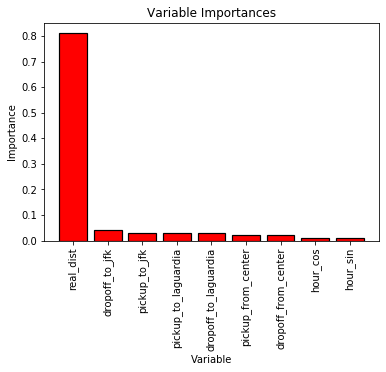

In [6]:
def plot_feature_importances_bar(feature_importances):
    %matplotlib inline
    x_values = list(range(len(feature_importances)))
    plt.bar(x_values, [i[1] for i in feature_importances], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
    plt.xticks(x_values, [i[0] for i in feature_importances], rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Variable')
    plt.title('Variable Importances')

plot_feature_importances_bar(feature_importances)

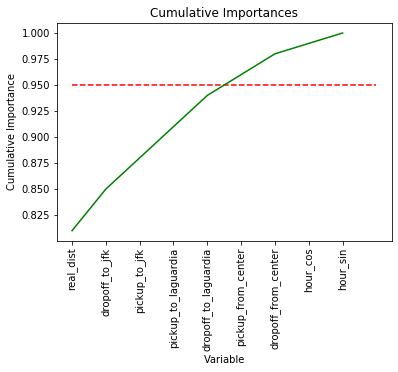

In [7]:
def plot_feature_importances_cumulative(feature_importances):
    %matplotlib inline
    x_values = list(range(len(feature_importances)))
    # List of features sorted from most to least important
    sorted_importances = [importance[1] for importance in feature_importances]
    sorted_features = [importance[0] for importance in feature_importances]
    # Cumulative importances
    cumulative_importances = np.cumsum(sorted_importances)
    # Make a line graph
    plt.plot(x_values, cumulative_importances, 'g-')
    # Draw line at 95% of importance retained
    plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
    # Format x ticks and labels
    plt.xticks(x_values, sorted_features, rotation = 'vertical')
    # Axis labels and title
    plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

plot_feature_importances_cumulative(feature_importances)

In [13]:
import lightgbm as lgb

def lgb_train(training_data):
    lgb_regressor = lgb.LGBMRegressor(objective='regression', random_state=5)
    lgb_regressor.fit(training_data[FEATURES], training_data[LABEL])
    return lgb_regressor.predict(TEST[FEATURES])

Y_PREDICT_LGB = lgb_train(pd.concat(TRAINING_LIST))
#Y_PREDICT_LGB = lgb_train(TRAIN)

In [14]:
from sklearn import metrics
import numpy as np

def calc_rmse(y_test, y_prediction):
    # Calculating "Mean Square Error" (MSE):
    mse = metrics.mean_squared_error(y_test, y_prediction)

    # Using numpy sqrt function to take the square root and calculate "Root Mean Square Error" (RMSE)
    return np.sqrt(mse)

print(f'SGB RMSE: {calc_rmse(TEST[LABEL], Y_PREDICT_SGD)}')
print(f'RF RMSE: {calc_rmse(TEST[LABEL], Y_PREDICT_RF)}')
print(f'LGB RMSE: {calc_rmse(TEST[LABEL], Y_PREDICT_LGB)}')

SGB RMSE: 5.364220742355958
RF RMSE: 4.093538688772342
LGB RMSE: 4.717906253777697
